# Heart Failure Prediction:

## Importing Dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kaggle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



KAGGLE_DATASET = "andrewmvd/heart-failure-clinical-data"
FILE_NAME = "heart_failure_clinical_records_dataset.csv"
cwd = os.getcwd()
DATASET_FOLDER_PATH = os.path.join(cwd, "dataset")

## Fetch and Load the Dataset

In [11]:
def fetch_dataset():
    """
    Downloads the dataset from Kaggle if not present
    """
    if not os.path.isfile(FILE_NAME):
        os.makedirs(DATASET_FOLDER_PATH, exist_ok=True)
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(KAGGLE_DATASET, path=DATASET_FOLDER_PATH, unzip=True)

def load_dataset():
    """
    Returns the dataframe containing the dataset
    """
    csv_path = os.path.join(DATASET_FOLDER_PATH, FILE_NAME)
    return pd.read_csv(csv_path)

fetch_dataset()
dataset = load_dataset()


## Exploring the dataset
Description of the features:
- **age**: Age of the patient
- **anaemia**: Decrease of red blood cells or hemoglobin (boolean)
- **creatinine_phosphokinase**: Level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: If the patient has diabetes (boolean)
- **ejection_fraction**: Percentage of blood leaving the heart at each contraction (percentage)
- **high_blood_pressure**: If the patient has hypertension (boolean)
- **platelets**: Platelets in the blood (kiloplatelets/mL)
- **serum_creatinine**: Level of serum creatinine in the blood (mg/dL)
- **serum_sodium**: Level of serum sodium in the blood (mEq/L)
- **sex**: Woman or man (binary)
- **smoking**: If the patient smokes (binary)
- **time**: Nan
- **DEATH_EVENT**: If the heart attack leads to death (binary)

In [12]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [13]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [14]:
### Checking for Null values:
dataset.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

## Distribution of the dataset

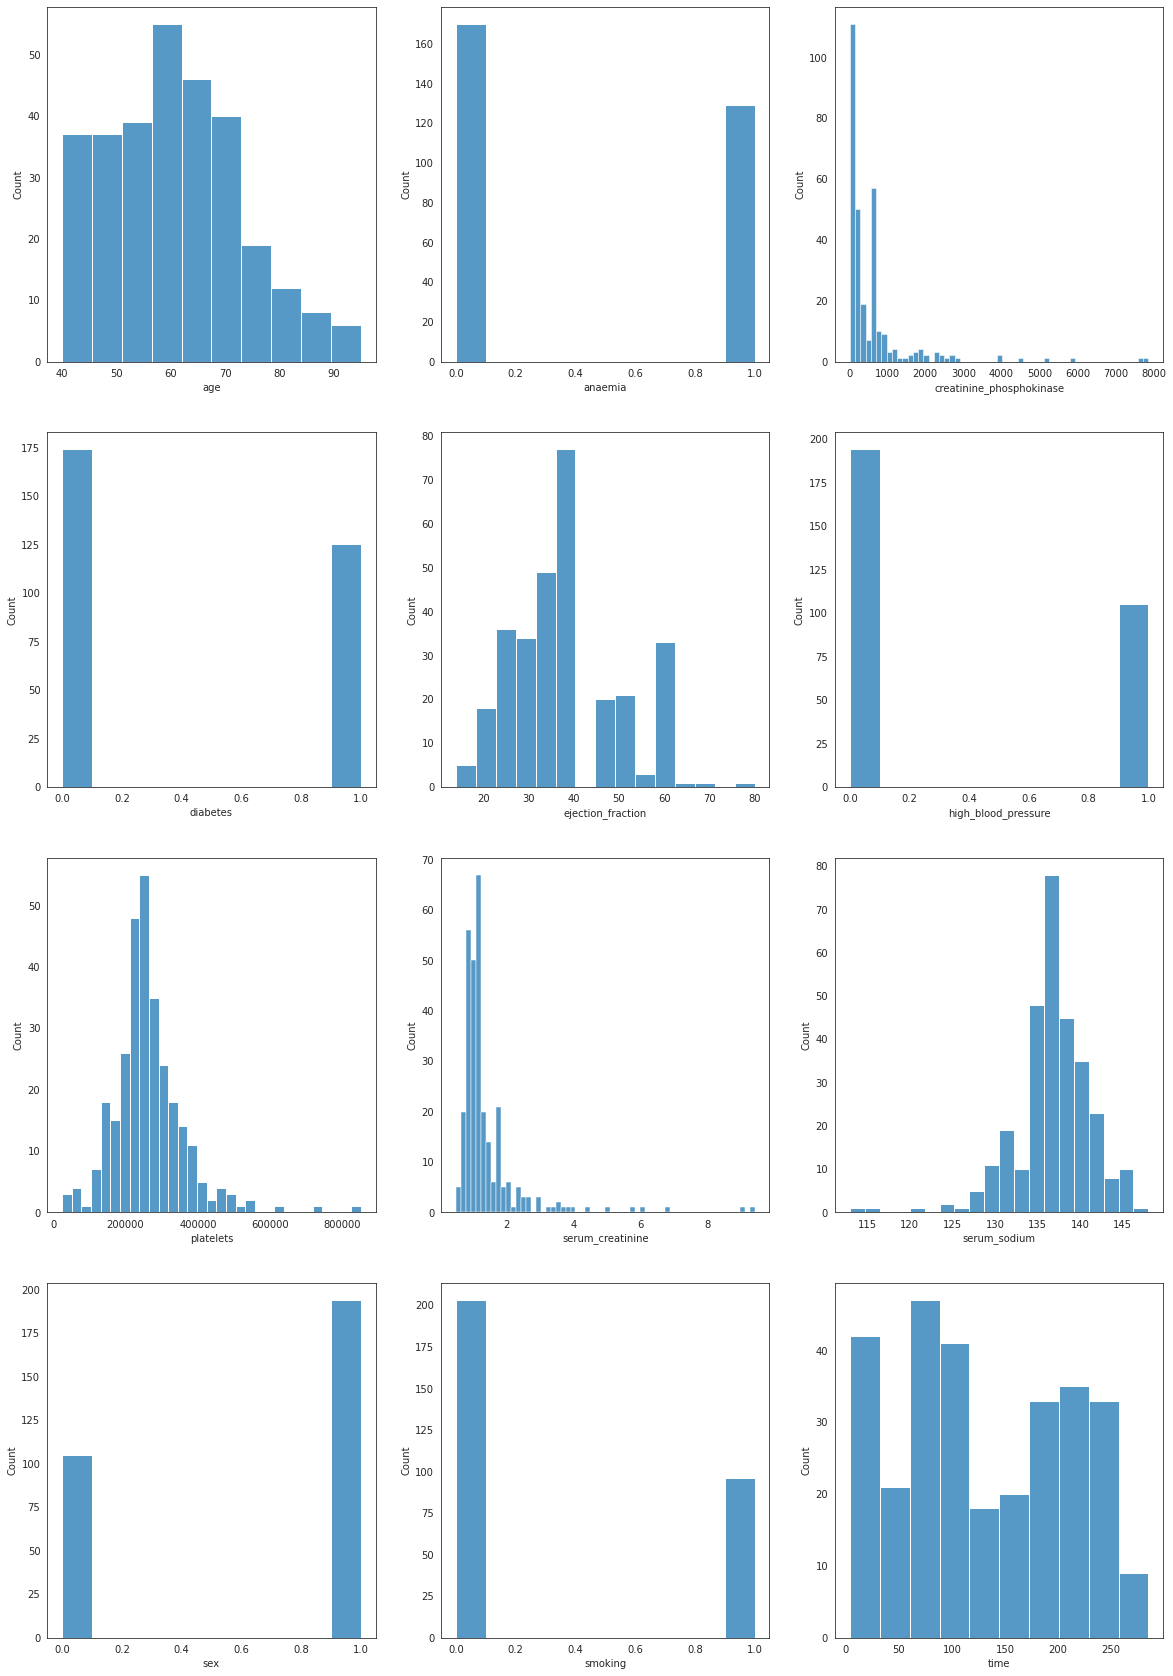

In [15]:
plt.figure(figsize=(20,30))

for i, column in enumerate(dataset.drop(["DEATH_EVENT"], axis=1).columns, 1):
    plt.subplot(4,3,i)
    sns.histplot(dataset[column])
plt.show()

## Linear Correlation of the different features:
As we can see **age, serum_creatinine** are linearly correlated with DEATH_EVENT; while **time, ejection_fraction, serum_sodium** are inversely correlated with DEATH_EVENT.

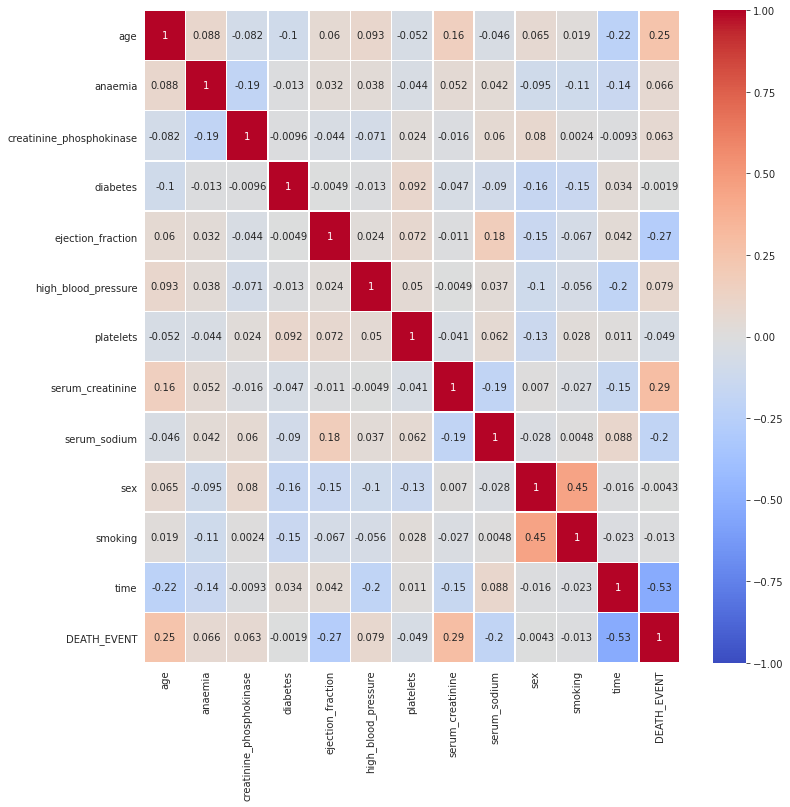

In [16]:
corr = dataset.corr()
ax, fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr, vmax=1,vmin=-1, annot=True, linewidths=.5, cmap="coolwarm")
plt.show()

# Model Training
Importing classes from utils.py

## LinearlyCorrelatedFeatures:
A custom transformer that transforms X to have only the features that are linearly correlated to y. The threshold for the amount of correlation can be controlled.

## HeartFailurePrediction:
A Class that compares the effects of using without feature selection and using the Highly Correlated Features. Prints the confusion plot for both the cases for a given model.

In [17]:
# Created custom classes for doing 

RANDOM_STATE=42
from utils import LinearlyCorrelatedFeatures, HeartFailurePrediction

predictor = HeartFailurePrediction(dataset, scoring='f1', cv=2, n_jobs=10, verbose=0, print_grid_scores=False, print_prediction_results=False, random_state=RANDOM_STATE)

## 1. Logistic Regression

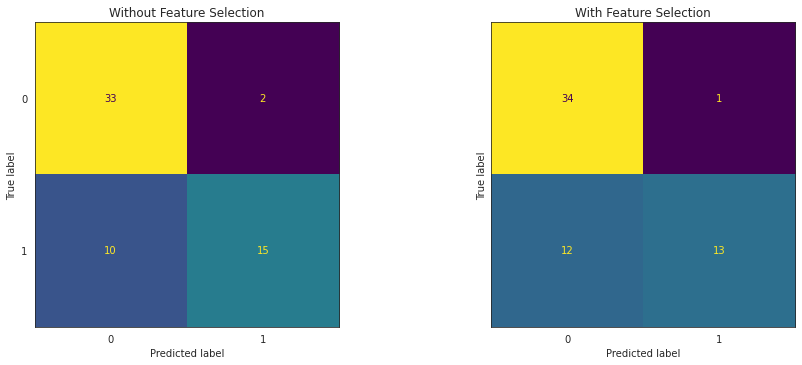

In [18]:
log_reg = LogisticRegression(random_state=RANDOM_STATE)
log_reg_parameters = {
    "penalty": ['l2'],
    'C': [0.25, 0.4, 0.5, 0.75]
    }
predictor.main_wrapper(log_reg, log_reg_parameters, "Logistic Regression")

## 2. Support Vector Classifier:

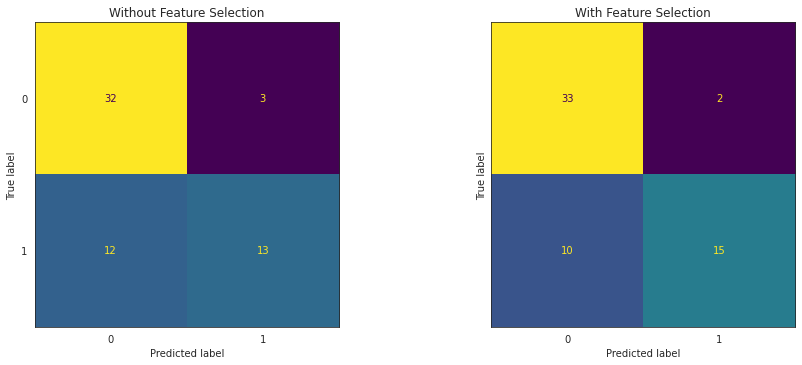

In [19]:
svc = SVC(random_state=RANDOM_STATE)
svc_parameters = {
    'kernel': ['linear'],
    'C': [1],
}
predictor.main_wrapper(svc, svc_parameters, "Suport Vector Classifier")

## 3. Decision Tree Classifier:

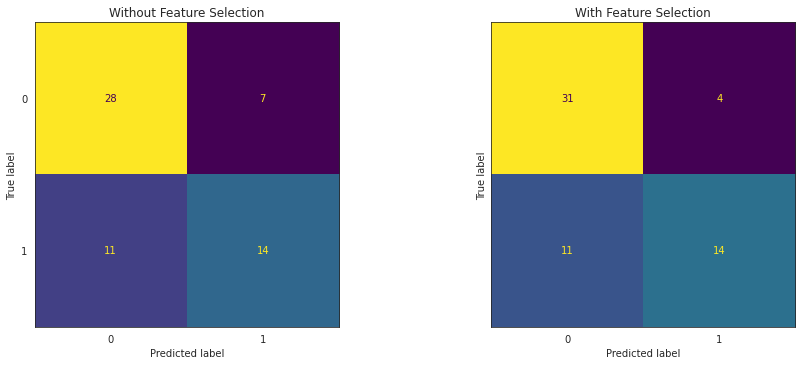

In [20]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='gini')
dt_parameters = {
    'max_depth': [1,2,3,None],
    'max_features': [2,3,4,None],
    'max_leaf_nodes': [2,3,4,None]
}
predictor.main_wrapper(dt, dt_parameters, "Decision Tree Classifier")

## 4. Random Forest Classifier

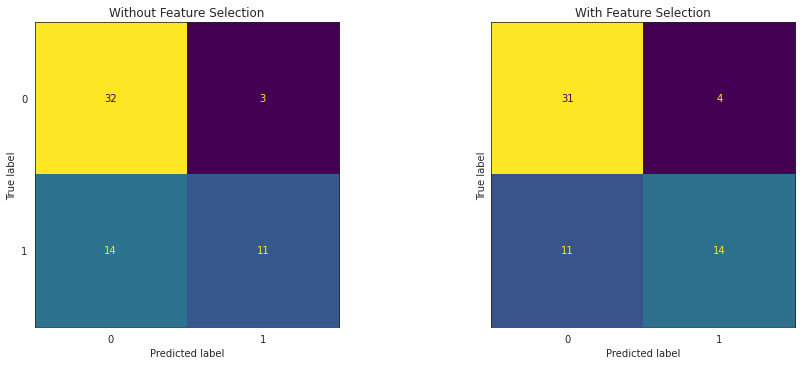

In [21]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_parameters = {
    'criterion': ['gini'],
    'max_depth': [4,5,6],
    'n_estimators': [75,100,125],
    'max_leaf_nodes': [5, None]
}
predictor.main_wrapper(rf, rf_parameters, "Random Forst Classifier")

## 5. Gradient Boosting Classifier

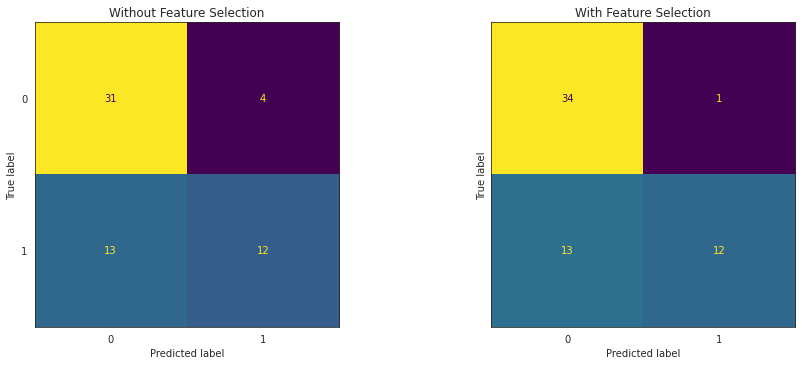

In [22]:
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf_parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.5, 0.05],
    'n_estimators': [50,100,150],
    'max_depth': [1,3,5],

}
predictor.main_wrapper(gb_clf, gb_clf_parameters, "Gradient Boosting Classifier")

## 6. K Nearest Neighbors

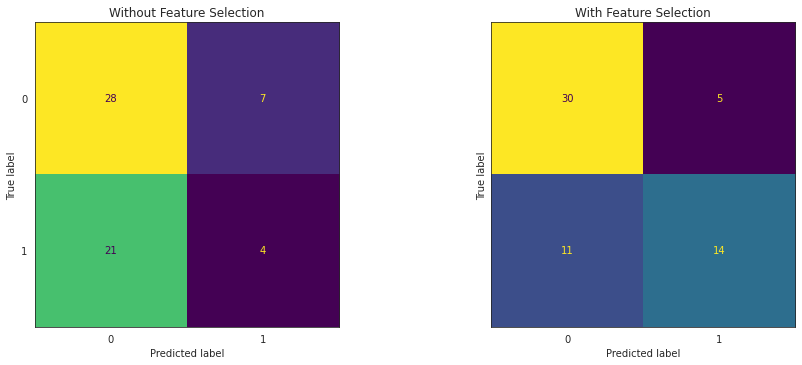

In [23]:
knn_clf = KNeighborsClassifier()
knn_clf_parameters = {
    'n_neighbors': [2,3,5,8,10],
}
predictor.main_wrapper(knn_clf, knn_clf_parameters, "K Nearest Neighbors")

# Final Results:

In [24]:
print("Scores are displayed for models Without Feature Selection vs Models With Feature Selection")
for model, scores in predictor.all_test_scores.items():
    print("{:_^40}".format(model))
    for key in scores[0].keys():
        print("{:10s} : {:.2f}      vs      {:.2f}".format(key, scores[0][key], scores[1][key]))

Scores are displayed for models Without Feature Selection vs Models With Feature Selection
__________Logistic Regression___________
Accuracy   : 80.00      vs      78.33
Precision  : 88.24      vs      92.86
Recall     : 60.00      vs      52.00
F1 Score   : 71.43      vs      66.67
________Suport Vector Classifier________
Accuracy   : 75.00      vs      80.00
Precision  : 81.25      vs      88.24
Recall     : 52.00      vs      60.00
F1 Score   : 63.41      vs      71.43
________Decision Tree Classifier________
Accuracy   : 70.00      vs      75.00
Precision  : 66.67      vs      77.78
Recall     : 56.00      vs      56.00
F1 Score   : 60.87      vs      65.12
________Random Forst Classifier_________
Accuracy   : 71.67      vs      75.00
Precision  : 78.57      vs      77.78
Recall     : 44.00      vs      56.00
F1 Score   : 56.41      vs      65.12
______Gradient Boosting Classifier______
Accuracy   : 71.67      vs      76.67
Precision  : 75.00      vs      92.31
Recall     : 48.00  